# KE5006 Applied Research

### Identifying enhancers and their strength with deep neural networks

## Layer 1 Model with Physiochemical Property Features - Results

## Summary of Findings
* Validation Accuracy :
    * Ensemble of models of 2x16 GRU, 1x16 Dense
        * The best model ensemble of 5 models (around the best model) has an accuracy of 77.449%. The model ensemble beats the best single model accuracy of 76.735% from the same training run.
    * Ensemble of models of 1x16 conv1D, 2x16 GRU bidirectional, 1x8 Dense
        * The best model ensemble of 3 models (around the best model) has an accuracy of 76.429%. The model ensemble beats the best single model accuracy of 76.224% from the same training run.
* Test Accuracy :
    * Both ensembles achieved higher accuracy of **75.25%** and **75.50%** than the best single models of 74.00% and 73.75%. The single models were from training runs without warm restarts. 

## Load libraries

In [1]:
# Set the working directory (which contains the directories source, data, etc.)
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5006-AppliedResearch', 'enhancer'))
os.getcwd()

'/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer'

In [2]:
# Check if the directory containing the source files are in the path.
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import pickle

import myUtilities as mu

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [4]:
pd.set_option('precision', 3)

## Load data

In [5]:
enhancer_df = pd.read_csv(os.path.join('data', 'enhancer.csv'))
enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [6]:
enhancer_df['enhancer'] = np.ones((len(enhancer_df),))

In [7]:
enhancer_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


In [8]:
non_enhancer_df = pd.read_csv(os.path.join('data', 'non_enhancer.csv'))
non_enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [9]:
non_enhancer_df['enhancer'] = np.zeros((len(non_enhancer_df),))

In [10]:
non_enhancer_df.head()

,id,sequence,enhancer
0,CHRX_2970600_2970800,CAGTCACATCTGTAATCACAATACGTTGGGAGGCTGAGGCAGGAGG...,0.0
1,CHRX_6179400_6179600,ACTTTGAAGAAGTCAGTCATCAAGATGAGAGACCCAACTGTCAAGC...,0.0
2,CHRX_11003079_11003279,TCGGCCTCCCAAAGTGCTGGGATTATAGGCATGAGCTACTGCACCC...,0.0
3,CHRX_22042679_22042879,TGGGAGCTGTATCAATCATGTTTTTTATTTTCTATATTTTATGATG...,0.0
4,CHRX_23280479_23280679,TACAGCAAATAGCCTTGGCAGATACAGTGTTTCCCTCCAGAGCAAA...,0.0


## Combine the data frames to form a single dataset

In [11]:
all_data_df = pd.concat([enhancer_df, non_enhancer_df])
all_data_df.reset_index(drop=True, inplace=True)
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 3 columns):
id          2968 non-null object
sequence    2968 non-null object
enhancer    2968 non-null float64
dtypes: float64(1), object(2)
memory usage: 69.6+ KB


In [12]:
all_data_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


All the sequences are of length 200 characters.

In [13]:
all_data_df['sequence'].map(lambda x: len(x)).value_counts()

200    2968
Name: sequence, dtype: int64

## Load the physiochemical property data

In [14]:
pcp_df = pd.read_csv(os.path.join('data', 'S2.csv'), index_col=0)
pcp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, AA to TT
Data columns (total 6 columns):
Rise     16 non-null float64
Roll     16 non-null float64
Shift    16 non-null float64
Slide    16 non-null float64
Tilt     16 non-null float64
Twist    16 non-null float64
dtypes: float64(6)
memory usage: 896.0+ bytes


In [15]:
scaler = MinMaxScaler()
pcp_df.loc[:, :] = scaler.fit_transform(pcp_df.values)
pcp_df

,Rise,Roll,Shift,Slide,Tilt,Twist
AA,0.430,0.403,1.000,0.545,0.4,0.833
AC,0.818,0.696,0.619,1.000,0.7,0.833
AG,0.258,0.316,0.763,0.773,0.3,0.792
AT,0.861,1.000,0.320,0.864,0.6,0.750
CA,0.045,0.221,0.361,0.091,0.1,0.292
CC,0.548,0.171,0.732,0.545,0.3,1.000
CG,0.000,0.304,0.371,0.000,0.0,0.333
CT,0.258,0.316,0.763,0.773,0.3,0.792
GA,0.706,0.278,0.619,0.500,0.4,0.833
GC,1.000,0.536,0.495,0.500,1.0,0.750


## Prepare the sequence data for modelling

Create a transformation pipleline to prepare the training dataset for RNN.

In [16]:
# This class selects the desired attributes and drops the rest.
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

In [17]:
# This class converts a nucleotide base (A, C, G, T) to one-hot-encoding.
class one_hot_encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.tokenizer = Tokenizer(num_words=4, lower=False, char_level=True)

    def fit(self, X, y=None):
        # Note that X is a data frame.
        # Fit the tokenizer on the 1st sequence in the dataset.
        self.tokenizer.fit_on_texts(X.iloc[0, 0])
        self.len_sequence = len(X.iloc[0, 0])
        return self

    def transform(self, X):
        # Note that X is a data frame.
        one_hot_X = X.iloc[:, 0].map(lambda x: self.tokenizer.texts_to_matrix(x, mode='binary')).values
        one_hot_X = np.concatenate(one_hot_X)
        one_hot_X = np.reshape(one_hot_X, (-1, self.len_sequence, 4))
        return one_hot_X

In [18]:
# This class converts a sequence of nucleotide bases (A, C, G, T) to a sequence of dinucleotides and then to a sequence of pysiochemical properties of each dinucleotide.
class pcp_encoder(BaseEstimator, TransformerMixin):

    def __init__(self, pcp_df):
        self.pcp_df = pcp_df

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Note that X is a data frame.
        dinuc_seq = X.iloc[:, 0].map(lambda x: [ x[i:i+2] for i in range(len(x) - 1) ])
        pcp_seq = dinuc_seq.map(lambda x: [ pcp_df[j][i] for i in x for j in pcp_df.columns.tolist() ])
        # Pad with -1 for last element of sequence; it does not have an associated di-nucleotide
        pcp_seq = pcp_seq.map(lambda x: np.array(x + [-1. for i in range(len(pcp_df.columns))]).reshape((len(X.iloc[0, 0]), len(pcp_df.columns)))).values
        # pandas values returns a 1-D array of objects; use numpy stack to reshape it to a multi-dimensional array
        return np.stack(pcp_seq)

In [19]:
# This class shapes a numpy array.
class Array_Shaper(BaseEstimator, TransformerMixin):
    
    def __init__(self, shape):
        self.shape = shape
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.reshape(self.shape)

In [20]:
attrbs = ['sequence']
num_bases = 4  # number of nucleotide bases
num_pcp = 6  # number of di-nucleotide physiochemical properties
len_seq = len(all_data_df['sequence'][0])
one_hot_pipeline = Pipeline([
    ('selector', DataFrameSelector(attrbs)),
    ('one_hot_encoder', one_hot_encoder()),
    ('array_shaper2D', Array_Shaper((-1, num_bases)))
])
pcp_pipeline = Pipeline([
    ('selector', DataFrameSelector(attrbs)),
    ('pcp_encoder', pcp_encoder(pcp_df)),
    ('array_shaper2D', Array_Shaper((-1, num_pcp)))
])
union_pipeline = FeatureUnion(transformer_list=[
    ("one_hot_pipeline", one_hot_pipeline),
    ("pcp_pipeline", pcp_pipeline)
])
my_pipeline = Pipeline([
    ('feature_combiner', union_pipeline),
    ('array_shaper3D', Array_Shaper((-1, len_seq, num_bases + num_pcp)))
])

In [21]:
X = my_pipeline.fit_transform(all_data_df)
X.shape

(2968, 200, 10)

Check the 1st sequence is correctly encoded.

In [22]:
X[0, :10, :]

array([[0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 0.        , 0.        , 1.        , 0.81818182,
        0.69581749, 0.6185567 , 1.        , 0.7       , 0.83333333],
       [0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 0.        , 0.        , 1.        , 0.43030303,
        0.40304183, 1.        , 0.54545455, 0.4       , 0.83333333],
       [0.        , 0.        , 0.        , 1.        , 0.86060606,
        1.        , 0.31958763, 0.86363636, 0.6       , 0.75      ],
       [0.        , 0.        , 1.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 1.        , 0.        , 0.        , 0.81818182,
        0.69581749, 0.6185567 , 1.        , 0.7       , 0.83333333],
       [0.        , 0.        , 1.       

In [23]:
X[0, -10:, :]

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.43030303,
         0.40304183,  1.        ,  0.54545455,  0.4       ,  0.83333333],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.04545455,
         0.22053232,  0.36082474,  0.09090909,  0.1       ,  0.29166667],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.81818182,
         0.69581749,  0.6185567 ,  1.        ,  0.7       ,  0.83333333],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.70606061,
         0.27756654,  0.6185567 ,  0.5       ,  0.4       ,  0.83333333],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.54848485,
         0.17110266,  0.73195876,  0.54545455,  0.3       ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.25757576,
         0.31558935,  0.7628866 ,  0.77272727,  0.3       ,  0.79166667],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.13636364

In [24]:
y = all_data_df['enhancer'].values
y.shape

(2968,)

In [25]:
y[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Split the dataset into train / validation sets

For the initial base model, we will use a simple train / validation split. 5-fold cross-validation will be used during model fine-tuning to obtain the final model.

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=123)

In [27]:
X_train.shape

(1988, 200, 10)

In [28]:
X_train[0][:10]

array([[0.        , 0.        , 0.        , 0.        , 0.25757576,
        0.31558935, 0.7628866 , 0.77272727, 0.3       , 0.79166667],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.13636364, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.81818182,
        0.69581749, 0.6185567 , 1.        , 0.7       , 0.83333333],
       [0.        , 0.        , 0.        , 0.        , 0.54848485,
        0.17110266, 0.73195876, 0.54545455, 0.3       , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 0.        , 0.        , 1.        , 0.43030303,
        0.40304183, 1.        , 0.54545455, 0.4       , 0.83333333],
       [0.        , 0.        , 0.        , 1.        , 0.86060606,
        1.        , 0.31958763, 0.86363636, 0.6       , 0.75      ],
       [0.        , 0.        , 1.       

In [29]:
y_train.shape

(1988,)

In [30]:
y_train[0]

1.0

## Load models

### Ensemble of models of 2x16 GRU, 1x16 Dense
* Dropouts (.1/.1/.1)
* Warm restarts cycle = 200, lr=0.003
* Saved models are best in each cycle

In [31]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [32]:
# Best model
model = load_model(os.path.join('models', 'pcp-2x16gru1x16dense-dropout010101-wr41.best-epch1283.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 16)          1344      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


In [33]:
results_df = pd.DataFrame()

In [34]:
results_df['best'] = pd.Series(model.predict_classes(X_val, batch_size=128, verbose=1).flatten())

980/980 [==============================] - 1s 742us/step


In [35]:
best_acc = 100. * (len(y_val) - (np.abs(results_df['best'].values - y_val)).sum()) / len(y_val)
best_acc

76.73469387755102

The best model from training was saved separately from the models saved in each of the cycles below. It will be the same as one of the best models from the cycles. The best model from the first cycle (1-200 epoch) is not used as the loss had not converged to a minimum.

In [36]:
# Path to the weights saved for the best model in each cycle
path = [os.path.join('models', 'pcp-2x16gru1x16dense-dropout010101-wr41-weights', i)
        for i in ['model_wgts_cyc0400.h5', 'model_wgts_cyc0600.h5', 'model_wgts_cyc0800.h5', 'model_wgts_cyc1000.h5', 'model_wgts_cyc1200.h5', 'model_wgts_cyc1400.h5', 'model_wgts_cyc1600.h5',
                 'model_wgts_cyc1800.h5', 'model_wgts_cyc2000.h5', 'model_wgts_cyc2200.h5', 'model_wgts_cyc2400.h5', 'model_wgts_cyc2600.h5', 'model_wgts_cyc2800.h5', 'model_wgts_cyc3000.h5']]
path

['models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc0400.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc0600.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc0800.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1000.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1200.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1400.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1600.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1800.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc2000.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc2200.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc2400.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc2600.h5',
 'models/pcp-2x16gru1x16dens

In [37]:
# Calculate the predictions for the best models in each cycle.
for idx, a_file in enumerate(path):
    model.load_weights(filepath=a_file, by_name=False)
    results_df['model' + str(idx)] = model.predict_classes(X_val, batch_size=128, verbose=1)

980/980 [==============================] - 0s 510us/step


In [38]:
# Compare the predictions of each cycle's best model with the overall best model.
# Count the number of different predictions.
for i in range(14):
    print((results_df['best'] - results_df['model' + str(i)]).abs().sum())

116
99
86
64
58
0
31
44
66
61
65
74
83
82


In [39]:
# calculate the accuracy for each model
for i in range(14):
    acc = 100. * (len(y_val) - (np.abs(results_df['model' + str(i)].values - y_val)).sum()) / len(y_val)
    print('model' + str(i) + ' = {:06.3f}%'.format(acc))

model0 = 75.510%
model1 = 76.224%
model2 = 76.531%
model3 = 76.531%
model4 = 76.531%
model5 = 76.735%
model6 = 76.429%
model7 = 75.918%
model8 = 75.918%
model9 = 75.408%
model10 = 75.612%
model11 = 75.306%
model12 = 75.408%
model13 = 75.714%


#### Evalute the Model Ensembles
#### Use models 1-13 (13 models)

In [40]:
acc_list = []

In [41]:
cols = results_df.columns.tolist()
cols.remove('best')
cols.remove('model0')

# Decision threshold for majority voting
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))

threshold = 6


In [42]:
# Calculate the ensemble prediction
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
# Calculate the model ensemble accuracy 
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('1-13', 13, acc))

model ensemble accuracy = 76.531%


#### Use models 2-12 (11 models)

In [44]:
cols = results_df.columns.tolist()
for i in ['best', 'model0', 'model1', 'model13', 'ensemble']:
    cols.remove(i)
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

threshold = 5


,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('2-12', 11, acc))

model ensemble accuracy = 76.633%


#### Use models 2-10 (9 models)

In [46]:
cols = results_df.columns.tolist()
for i in ['best', 'model0', 'model1', 'model11', 'model12', 'model13', 'ensemble']:
    cols.remove(i)
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

threshold = 4


,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('2-10', 9, acc))

model ensemble accuracy = 77.347%


#### Use models 2-8 (7 models)

In [48]:
cols = results_df.columns.tolist()
for i in ['best', 'model0', 'model1', 'model9', 'model10', 'model11', 'model12', 'model13', 'ensemble']:
    cols.remove(i)
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

threshold = 3


,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('2-8', 7, acc))

model ensemble accuracy = 77.245%


#### Use models 3-7 (5 models)

In [50]:
cols = results_df.columns.tolist()
for i in ['best', 'model0', 'model1', 'model2', 'model8', 'model9', 'model10', 'model11', 'model12', 'model13', 'ensemble']:
    cols.remove(i)
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

threshold = 2


,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('3-7', 5, acc))

model ensemble accuracy = 77.449%


#### Use models 4-6 (3 models)

In [52]:
cols = results_df.columns.tolist()
for i in ['best', 'model0', 'model1', 'model2', 'model3', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12', 'model13', 'ensemble']:
    cols.remove(i)
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

threshold = 1


,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('4-6', 3, acc))

model ensemble accuracy = 76.837%


#### Use models 5, 9, 13 (3 models)

In [54]:
cols = ['model5', 'model9', 'model13']
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('5, 9, 13', 3, acc))

threshold = 1
model ensemble accuracy = 76.122%


#### Use models 2-6 (5 models)

In [55]:
cols = ['model2', 'model3', 'model4', 'model5', 'model6']
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('2-6', 5, acc))

threshold = 2
model ensemble accuracy = 76.837%


In [56]:
acc_df = pd.DataFrame(acc_list, columns=['Models', 'Number of models', 'Accuracy'])
acc_df

,Models,Number of models,Accuracy
0,1-13,13,76.531
1,2-12,11,76.633
2,2-10,9,77.347
3,2-8,7,77.245
4,3-7,5,77.449
5,4-6,3,76.837
6,"5, 9, 13",3,76.122
7,2-6,5,76.837


**Model ensemble 4** has the best accuracy. The model ensemble beats the best single model accuracy of 76.735%.

It is probably better to take a total of 5-9 models aound the best model.

### Ensemble of models of 1x16 conv1D, 2x16 GRU bidirectional, 1x8 Dense
* Dropouts (.6/.6/.6)
* Warm restarts cycle = 200, max_lr=.001
* Saved model are best in each cycle

In [57]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [58]:
acc_list = []

In [59]:
# Best model
model = load_model(os.path.join('models', 'pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44.best-epch871.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 16)           1456      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 96, 32)            3264      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
__________

In [60]:
results_df = pd.DataFrame()

In [61]:
results_df['best'] = pd.Series(model.predict_classes(X_val, batch_size=128, verbose=1).flatten())

980/980 [==============================] - 2s 2ms/step


In [62]:
best_acc = 100. * (len(y_val) - (np.abs(results_df['best'].values - y_val)).sum()) / len(y_val)
'{:06.3f}%'.format(best_acc)

'76.224%'

In [63]:
path = [os.path.join('models', 'pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights', i)
        for i in ['model_wgts_cyc0200.h5', 'model_wgts_cyc0400.h5', 'model_wgts_cyc0600.h5',
                  'model_wgts_cyc0800.h5', 'model_wgts_cyc1000.h5', 'model_wgts_cyc1200.h5',
                  'model_wgts_cyc1400.h5', 'model_wgts_cyc1600.h5',
                  'model_wgts_cyc1800.h5', 'model_wgts_cyc2000.h5']]
path

['models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc0200.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc0400.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc0600.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc0800.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc1000.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc1200.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc1400.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc1600.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc1800.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc2000.h5']

In [64]:
for idx, a_file in enumerate(path):
    model.load_weights(filepath=a_file, by_name=False)
    results_df['model' + str(idx)] = model.predict_classes(X_val, batch_size=128, verbose=1)

980/980 [==============================] - 1s 689us/step


In [65]:
for i in range(10):
    print((results_df['best'] - results_df['model' + str(i)]).abs().sum())

85
58
54
37
0
55
32
37
61
61


In [66]:
for i in range(10):
    acc = 100. * (len(y_val) - (np.abs(results_df['model' + str(i)].values - y_val)).sum()) / len(y_val)
    print('model' + str(i) + ' = {:06.3f}%'.format(acc))

model0 = 74.694%
model1 = 76.224%
model2 = 75.816%
model3 = 75.918%
model4 = 76.224%
model5 = 75.510%
model6 = 75.612%
model7 = 75.510%
model8 = 75.918%
model9 = 75.714%


#### Use models 1-9 (9 models)

In [67]:
cols = results_df.columns.tolist()
cols.remove('best')
cols.remove('model0')
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

threshold = 4


,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('1-9', 9, acc))

model ensemble accuracy = 76.020%


#### Use models 2-8 (7 models)

In [69]:
cols = results_df.columns.tolist()
for i in ['best', 'model0', 'model1', 'model9', 'ensemble']:
    cols.remove(i)
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

threshold = 3


,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('2-8', 7, acc))

model ensemble accuracy = 75.816%


#### Use models 2-6 (5 models)

In [71]:
cols = results_df.columns.tolist()
for i in ['best', 'model0', 'model1', 'model7', 'model8', 'model9', 'ensemble']:
    cols.remove(i)
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

threshold = 2


,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('2-6', 5, acc))

model ensemble accuracy = 75.816%


#### Use models 3-5 (3 models)

In [73]:
cols = results_df.columns.tolist()
for i in ['best', 'model0', 'model1', 'model2', 'model6', 'model7', 'model8', 'model9', 'ensemble']:
    cols.remove(i)
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df.head()

threshold = 1


,best,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,ensemble
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('3-5', 3, acc))

model ensemble accuracy = 75.918%


#### Use models 1, 4, 7 (3 models)

In [75]:
cols = ['model1', 'model4', 'model7']
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('1, 4, 7', 3, acc))

threshold = 1
model ensemble accuracy = 76.429%


#### Use models 1, 4, 8 (3 best models)

In [76]:
cols = ['model1', 'model4', 'model8']
threshold = len(cols) // 2
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.loc[:, cols].apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
acc = 100. * (len(y_val) - (np.abs(results_df['ensemble'].values - y_val)).sum()) / len(y_val)
print('model ensemble accuracy = {:06.3f}%'.format(acc))
acc_list.append(('1, 4, 8', 3, acc))

threshold = 1
model ensemble accuracy = 76.633%


In [77]:
acc_df = pd.DataFrame(acc_list, columns=['Models', 'Number of models', 'Accuracy'])
acc_df

,Models,Number of models,Accuracy
0,1-9,9,76.020
1,2-8,7,75.816
2,2-6,5,75.816
3,3-5,3,75.918
4,"1, 4, 7",3,76.429
5,"1, 4, 8",3,76.633


**Model ensemble 4** has the best accuracy. 5 is only for comparison because the best models will be in different cycles for different training runs.

Taking 3 models around the best model (1, 4, 7) beats the best single model accuracy of 76.224%.

 ## Evaluate model ensembles, best single models on the test set

In [78]:
test_df = pd.read_csv(os.path.join('data', 'independent.csv'))
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
id          400 non-null object
type        400 non-null object
sequence    400 non-null object
dtypes: object(3)
memory usage: 9.5+ KB


In [79]:
test_df.head()

,id,type,sequence
0,Chr11_6627824_6628024,strong,ATGCTGCCAGAAGGAAAAGGGGTGGAATTAATGAAACTGGAAGGTT...
1,Chr11_9587224_9587424,strong,GGCATTTTTTAACCTGTGTTTCATTTTCATCTGTGAAATGTGAATA...
2,Chr11_65187024_65187224,strong,GAAACCACAGAGCTGACCTGGCTTCAGAACAAGATGTGGGGCTCCA...
3,Chr10_74014594_74014794,strong,TTTGCATAGGGGCATTACCACTGGACTTGGGCTCAGAGCAAGTGTT...
4,Chr10_105667810_105668010,strong,CGGGAGGCGGGGGTTGCAGTGAGCCAAGATCACACCACTGCACTCC...


In [80]:
test_df['type'].value_counts()

non-enhancer    200
strong          100
weak            100
Name: type, dtype: int64

In [81]:
test_df['enhancer'] = test_df['type'].map(lambda x: 0.0 if x == 'non-enhancer' else 1.0)

In [82]:
test_df.head()

,id,type,sequence,enhancer
0,Chr11_6627824_6628024,strong,ATGCTGCCAGAAGGAAAAGGGGTGGAATTAATGAAACTGGAAGGTT...,1.0
1,Chr11_9587224_9587424,strong,GGCATTTTTTAACCTGTGTTTCATTTTCATCTGTGAAATGTGAATA...,1.0
2,Chr11_65187024_65187224,strong,GAAACCACAGAGCTGACCTGGCTTCAGAACAAGATGTGGGGCTCCA...,1.0
3,Chr10_74014594_74014794,strong,TTTGCATAGGGGCATTACCACTGGACTTGGGCTCAGAGCAAGTGTT...,1.0
4,Chr10_105667810_105668010,strong,CGGGAGGCGGGGGTTGCAGTGAGCCAAGATCACACCACTGCACTCC...,1.0


In [83]:
test_df.loc[test_df['type'] == 'weak', :][:5]

,id,type,sequence,enhancer
100,hg19_ct_UserTrack_3545_11005,weak,TTATGGTCACCTTCGACCCCAGAAATAATGGTCTCTGTTGTCAGAT...,1.0
101,hg19_ct_UserTrack_3545_8529,weak,CATCCAGGCTTGGTCCTGGTTGTTCCTTGCTGTTATACCAGCCTGG...,1.0
102,hg19_ct_UserTrack_3545_7245,weak,TTGTTTTTTTCTGTTTTGAGACGGAGTTTCGCTCTTGTTGCCCAGG...,1.0
103,hg19_ct_UserTrack_3545_12669,weak,ACTGTTAAATAGCAAAAATTATTGAGCTCAAACCATCTAACCAGGT...,1.0
104,hg19_ct_UserTrack_3545_5404,weak,GAGAATTAAGTTTGTATTAAGTTGGAGACCAGGGCAGATGGAAAGA...,1.0


In [84]:
test_df.loc[test_df['type'] == 'non-enhancer', :][:5]

,id,type,sequence,enhancer
200,hg19_ct_UserTrack_3545_158,non-enhancer,AATTTTCTCATTTTCTCATAAAGTTTAACAGTTGTTTATTTGAGTC...,0.0
201,hg19_ct_UserTrack_3545_57,non-enhancer,ACTGGTTATCTTTTAGGACTAGTTAATATAACCCATTCTCTAACCA...,0.0
202,hg19_ct_UserTrack_3545_762,non-enhancer,ATGCATATGTTCTTCAGTAAACAGAGCAGCCACTGGTACCACAGGA...,0.0
203,hg19_ct_UserTrack_3545_78,non-enhancer,CTGCTCTCCTCGCTCTATAAAAGTCAGAGTGCCTAAGCTGTTAATT...,0.0
204,hg19_ct_UserTrack_3545_9,non-enhancer,GCTTGGGTATATATTGTCCAATATAGCAGGCCTCATGTGCTCCTTA...,0.0


In [85]:
# X_test = my_pipeline.fit_transform(test_df)  # wrong!
X_test = my_pipeline.transform(test_df)
X_test.shape

(400, 200, 10)

In [86]:
X_test[0, :10, :]

array([[0.        , 0.        , 0.        , 1.        , 0.86060606,
        1.        , 0.31958763, 0.86363636, 0.6       , 0.75      ],
       [0.        , 0.        , 1.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.53612167, 0.49484536, 0.5       , 1.        , 0.75      ],
       [0.        , 0.        , 0.        , 0.        , 0.25757576,
        0.31558935, 0.7628866 , 0.77272727, 0.3       , 0.79166667],
       [0.        , 0.        , 1.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.53612167, 0.49484536, 0.5       , 1.        , 0.75      ],
       [0.        , 0.        , 0.        , 0.        , 0.54848485,
        0.17110266, 0.73195876, 0.54545455, 0.3       , 1.        ],
       [0.        , 0.        , 0.       

In [87]:
y_test = test_df['enhancer'].values
y_test.shape

(400,)

In [88]:
y_test[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Parameters, Functions for Scoring

In [89]:
acc_list = []

In [90]:
# customer scorer function for specificity
def specificity(y, y_pred):
    # print(y_pred)
    tn, fp = 0, 0
    for idx, a_pred in enumerate(y_pred):
        if a_pred and not(y[idx]):
            fp += 1
        elif not(a_pred) and not(y[idx]):
            tn += 1
    return tn/(tn+fp)

In [91]:
# function for all scores
def all_scores(y, y_pred, y_pred_proba):
    acc = accuracy_score(y, y_pred) * 100.
    recall = recall_score(y, y_pred) * 100.
    spec = specificity(y, y_pred) * 100.
    auc = roc_auc_score(y, y_pred_proba) * 100.
    mcc = matthews_corrcoef(y, y_pred)
    return (acc, mcc, recall, spec, auc)

### 2x16 GRU, 1x16 Dense Best Single Model
* Dropout 0.1
* Best accuracy @epoch 865

In [92]:
# Best model
model = load_model(os.path.join('models', 'pcp-2x16gru1x16dense-dropout0101.best-epch865.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 16)          1344      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


In [93]:
y_pred = model.predict_classes(X_test, batch_size=None, verbose=1)

400/400 [==============================] - 1s 3ms/step


In [94]:
y_pred_proba = model.predict_proba(X_test, batch_size=None, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [95]:
y_pred[:10]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [96]:
y_pred_proba[:10]

array([[0.8774476 ],
       [0.50002277],
       [0.9146379 ],
       [0.8093204 ],
       [0.45847175],
       [0.87338626],
       [0.7477188 ],
       [0.7744072 ],
       [0.82469285],
       [0.93638813]], dtype=float32)

In [97]:
all_scores(y_test, y_pred, y_pred_proba)

(74.0, 0.4800960288096034, 75.0, 73.0, 79.63)

In [98]:
acc_list.append(('2x16GRU 1x16D', 'single') + all_scores(y_test, y_pred, y_pred_proba))

In [99]:
fpr0, tpr0, threshold0 = roc_curve(y_test, y_pred_proba)

### 1x16 Conv1D, 2x16 GRU Bidirectional, 1x8 Dense Best Single Model
* Dropout 0.6
* Best accuracy @epoch 693

In [100]:
# Best model
model = load_model(os.path.join('models', 'pcp-1x16cv-2x16gruB-1x8d-dropout060606.best-epch693.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 192, 16)           1456      
_________________________________________________________________
batch_normalization_3 (Batch (None, 192, 16)           64        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 96, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 96, 32)            3264      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
__________

In [101]:
y_pred = model.predict_classes(X_test, batch_size=None, verbose=1)

400/400 [==============================] - 2s 4ms/step


In [102]:
y_pred_proba = model.predict_proba(X_test, batch_size=None, verbose=1)

400/400 [==============================] - 1s 3ms/step


In [103]:
acc_list.append(('1x16 Conv1D 2x16 GRU-B 1x8 Dense', 'single') + all_scores(y_test, y_pred, y_pred_proba))

In [104]:
fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred_proba)

### Model Ensemble of 2x16 GRU, 1x16 Dense using 5 models
* Dropouts 0.1
* Warm restarts cycle = 200, lr=0.003
* Using models 3-7 out of 0-10

In [105]:
# Best model. Use this model to load the saved weights for the model ensemble.
model = load_model(os.path.join('models', 'pcp-2x16gru1x16dense-dropout010101-wr41.best-epch1283.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 16)          1344      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


In [106]:
results_df = pd.DataFrame()

In [107]:
path = [os.path.join('models', 'pcp-2x16gru1x16dense-dropout010101-wr41-weights', i)
        for i in ['model_wgts_cyc1000.h5', 'model_wgts_cyc1200.h5', 'model_wgts_cyc1400.h5',
                  'model_wgts_cyc1600.h5', 'model_wgts_cyc1800.h5']]
path

['models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1000.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1200.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1400.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1600.h5',
 'models/pcp-2x16gru1x16dense-dropout010101-wr41-weights/model_wgts_cyc1800.h5']

In [108]:
for idx, a_file in enumerate(path):
    model.load_weights(filepath=a_file, by_name=False)
    results_df['model' + str(idx)] = pd.Series(model.predict_classes(X_test, batch_size=128, verbose=1).flatten())

400/400 [==============================] - 0s 638us/step


In [109]:
results_df.head()

,model0,model1,model2,model3,model4
0,1,1,1,1,1
1,0,0,1,1,0
2,1,1,1,1,1
3,1,1,1,1,1
4,0,1,1,1,1


In [110]:
threshold = len(results_df.columns) // 2
ensemble_size = len(results_df.columns)
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df['ensemble_proba'] = results_df.iloc[:, :ensemble_size].apply(lambda x: x.sum() / ensemble_size, axis=1)
results_df.head()

threshold = 2


,model0,model1,model2,model3,model4,ensemble,ensemble_proba
0,1,1,1,1,1,1,1.0
1,0,0,1,1,0,0,0.4
2,1,1,1,1,1,1,1.0
3,1,1,1,1,1,1,1.0
4,0,1,1,1,1,1,0.8


In [111]:
results_df['ensemble_proba'].value_counts()

0.0    193
1.0    171
0.8     14
0.2      9
0.4      7
0.6      6
Name: ensemble_proba, dtype: int64

In [112]:
acc_list.append(('2x16GRU 1x16D', 'ensemble') +
                all_scores(y_test, results_df['ensemble'].values, results_df['ensemble_proba'].values))

In [113]:
fpr2, tpr2, threshold2 = roc_curve(y_test, results_df['ensemble_proba'].values)

### Model Ensemble of 1x16 Conv1D, 2x16 GRU Bidirectional, 1x8 Dense using 3 models
* Dropouts (.6/.6/.6)
* Warm restarts cycle = 200, max_lr=.001
* Using models 1, 4, 7 out of 0-9

In [114]:
# Best model
model = load_model(os.path.join('models', 'pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44.best-epch871.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 16)           1456      
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 96, 32)            3264      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
__________

In [115]:
results_df = pd.DataFrame()

In [116]:
path = [os.path.join('models', 'pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights', i)
        for i in ['model_wgts_cyc0400.h5', 'model_wgts_cyc1000.h5', 'model_wgts_cyc1600.h5']]
path

['models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc0400.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc1000.h5',
 'models/pcp-1x16cv-2x16gruB-1x8d-dropout060606-wr44-weights/model_wgts_cyc1600.h5']

In [117]:
for idx, a_file in enumerate(path):
    model.load_weights(filepath=a_file, by_name=False)
    results_df['model' + str(idx)] = pd.Series(model.predict_classes(X_test, batch_size=128, verbose=1).flatten())

400/400 [==============================] - 0s 849us/step


In [118]:
results_df.head()

,model0,model1,model2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


In [119]:
threshold = len(results_df.columns) // 2
ensemble_size = len(results_df.columns)
print('threshold = {}'.format(threshold))
results_df['ensemble'] = results_df.apply(lambda x: 1 if x.sum() > threshold else 0, axis=1)
results_df['ensemble_proba'] = results_df.iloc[:, :ensemble_size].apply(lambda x: x.sum() / ensemble_size, axis=1)
results_df.head()

threshold = 1


,model0,model1,model2,ensemble,ensemble_proba
0,1,1,1,1,1.0
1,1,1,1,1,1.0
2,1,1,1,1,1.0
3,1,1,1,1,1.0
4,1,1,1,1,1.0


In [120]:
results_df['ensemble_proba'].value_counts()

1.000    182
0.000    178
0.333     24
0.667     16
Name: ensemble_proba, dtype: int64

In [121]:
acc_list.append(('1x16 Conv1D 2x16 GRU-B 1x8 Dense', 'ensemble')
                + all_scores(y_test, results_df['ensemble'].values, results_df['ensemble_proba'].values))

In [122]:
fpr3, tpr3, threshold3 = roc_curve(y_test, results_df['ensemble_proba'].values)

### Summary of Results

In [123]:
acc_df = pd.DataFrame(acc_list, columns=['Model', 'Type', 'Accuracy(%)', 'MCC', 'Recall(%)', 'Specificity(%)',
                                         'AUC(%)'])
acc_df

,Model,Type,Accuracy(%),MCC,Recall(%),Specificity(%),AUC(%)
0,2x16GRU 1x16D,single,74.00,0.480,75.0,73.0,79.630
1,1x16 Conv1D 2x16 GRU-B 1x8 Dense,single,73.75,0.475,75.0,72.5,80.860
2,2x16GRU 1x16D,ensemble,75.25,0.506,73.0,77.5,76.161
3,1x16 Conv1D 2x16 GRU-B 1x8 Dense,ensemble,75.50,0.510,75.0,76.0,77.040


### ROC for Best Model

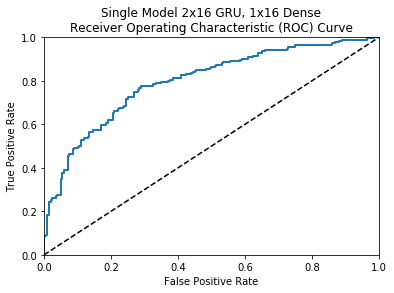

In [124]:
plt.plot(fpr0, tpr0, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Single Model 2x16 GRU, 1x16 Dense\nReceiver Operating Characteristic (ROC) Curve')
plt.savefig('roc_gru.svg')

In [125]:
fpr0

array([0.   , 0.   , 0.   , 0.005, 0.005, 0.01 , 0.01 , 0.015, 0.015,
       0.02 , 0.02 , 0.025, 0.025, 0.035, 0.035, 0.04 , 0.04 , 0.05 ,
       0.05 , 0.055, 0.055, 0.06 , 0.06 , 0.07 , 0.07 , 0.075, 0.075,
       0.085, 0.085, 0.09 , 0.09 , 0.1  , 0.1  , 0.105, 0.105, 0.11 ,
       0.11 , 0.12 , 0.12 , 0.13 , 0.13 , 0.135, 0.135, 0.145, 0.145,
       0.17 , 0.17 , 0.185, 0.185, 0.19 , 0.19 , 0.205, 0.205, 0.21 ,
       0.21 , 0.22 , 0.22 , 0.225, 0.225, 0.235, 0.235, 0.24 , 0.24 ,
       0.245, 0.245, 0.25 , 0.25 , 0.27 , 0.27 , 0.28 , 0.28 , 0.285,
       0.285, 0.29 , 0.29 , 0.325, 0.325, 0.335, 0.335, 0.35 , 0.35 ,
       0.37 , 0.37 , 0.375, 0.375, 0.385, 0.385, 0.41 , 0.41 , 0.425,
       0.425, 0.44 , 0.44 , 0.445, 0.445, 0.45 , 0.45 , 0.455, 0.455,
       0.485, 0.485, 0.495, 0.495, 0.5  , 0.5  , 0.51 , 0.51 , 0.515,
       0.515, 0.53 , 0.53 , 0.535, 0.535, 0.555, 0.555, 0.585, 0.585,
       0.59 , 0.59 , 0.61 , 0.61 , 0.625, 0.625, 0.64 , 0.64 , 0.65 ,
       0.65 , 0.66 ,

In [126]:
threshold0

array([1.9816194 , 0.98161936, 0.9635735 , 0.96266216, 0.95985943,
       0.95962465, 0.9337298 , 0.9323193 , 0.9046252 , 0.9043359 ,
       0.9041709 , 0.90181893, 0.89502823, 0.89256227, 0.89076126,
       0.88794386, 0.8877125 , 0.8829205 , 0.85231024, 0.851834  ,
       0.83366895, 0.83302295, 0.82351875, 0.8216179 , 0.79947835,
       0.7974072 , 0.79081404, 0.7904295 , 0.7673807 , 0.7644014 ,
       0.7555056 , 0.75062996, 0.7506037 , 0.7479359 , 0.7477188 ,
       0.7438371 , 0.7222127 , 0.7175945 , 0.7120783 , 0.7090033 ,
       0.7085643 , 0.7082407 , 0.6980663 , 0.6896591 , 0.6858595 ,
       0.66567296, 0.6554869 , 0.64259344, 0.63847244, 0.63191813,
       0.61865246, 0.6134197 , 0.6029156 , 0.601022  , 0.5974662 ,
       0.59152967, 0.5867772 , 0.5833102 , 0.58262515, 0.57325226,
       0.5667165 , 0.5643879 , 0.5636452 , 0.56069875, 0.5293908 ,
       0.52854675, 0.5278089 , 0.51734287, 0.50002277, 0.48842758,
       0.48414522, 0.469231  , 0.46569893, 0.4622096 , 0.45847

In [127]:
tpr0

array([0.   , 0.005, 0.085, 0.085, 0.09 , 0.09 , 0.185, 0.185, 0.245,
       0.245, 0.25 , 0.25 , 0.26 , 0.26 , 0.27 , 0.27 , 0.275, 0.275,
       0.35 , 0.35 , 0.375, 0.375, 0.39 , 0.39 , 0.455, 0.455, 0.465,
       0.465, 0.485, 0.485, 0.49 , 0.49 , 0.495, 0.495, 0.5  , 0.5  ,
       0.53 , 0.53 , 0.535, 0.535, 0.54 , 0.54 , 0.565, 0.565, 0.575,
       0.575, 0.595, 0.595, 0.605, 0.605, 0.62 , 0.62 , 0.65 , 0.65 ,
       0.66 , 0.66 , 0.67 , 0.67 , 0.675, 0.675, 0.68 , 0.68 , 0.685,
       0.685, 0.715, 0.715, 0.725, 0.725, 0.75 , 0.75 , 0.76 , 0.76 ,
       0.765, 0.765, 0.775, 0.775, 0.785, 0.785, 0.79 , 0.79 , 0.795,
       0.795, 0.8  , 0.8  , 0.805, 0.805, 0.815, 0.815, 0.825, 0.825,
       0.83 , 0.83 , 0.835, 0.835, 0.84 , 0.84 , 0.845, 0.845, 0.85 ,
       0.85 , 0.855, 0.855, 0.86 , 0.86 , 0.865, 0.865, 0.87 , 0.87 ,
       0.875, 0.875, 0.88 , 0.88 , 0.885, 0.885, 0.89 , 0.89 , 0.895,
       0.895, 0.9  , 0.9  , 0.91 , 0.91 , 0.915, 0.915, 0.93 , 0.93 ,
       0.935, 0.935,

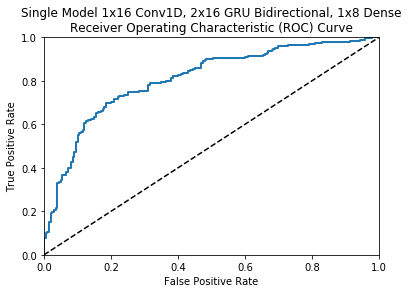

In [128]:
plt.plot(fpr1, tpr1, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Single Model 1x16 Conv1D, 2x16 GRU Bidirectional, 1x8 Dense\nReceiver Operating Characteristic (ROC) Curve')
plt.savefig('roc_conv1d.svg')

In [129]:
fpr1

array([0.   , 0.   , 0.   , 0.005, 0.005, 0.01 , 0.01 , 0.015, 0.015,
       0.02 , 0.02 , 0.025, 0.025, 0.03 , 0.03 , 0.035, 0.035, 0.04 ,
       0.04 , 0.045, 0.045, 0.05 , 0.05 , 0.055, 0.055, 0.065, 0.065,
       0.07 , 0.07 , 0.08 , 0.08 , 0.085, 0.085, 0.09 , 0.09 , 0.095,
       0.095, 0.1  , 0.1  , 0.105, 0.105, 0.11 , 0.11 , 0.115, 0.115,
       0.12 , 0.12 , 0.125, 0.125, 0.13 , 0.13 , 0.14 , 0.14 , 0.15 ,
       0.15 , 0.155, 0.155, 0.16 , 0.16 , 0.17 , 0.17 , 0.175, 0.175,
       0.18 , 0.18 , 0.185, 0.185, 0.2  , 0.2  , 0.21 , 0.21 , 0.22 ,
       0.22 , 0.225, 0.225, 0.24 , 0.24 , 0.25 , 0.25 , 0.285, 0.285,
       0.31 , 0.31 , 0.315, 0.315, 0.35 , 0.35 , 0.365, 0.365, 0.38 ,
       0.38 , 0.385, 0.385, 0.4  , 0.4  , 0.41 , 0.41 , 0.415, 0.415,
       0.43 , 0.43 , 0.435, 0.435, 0.445, 0.445, 0.45 , 0.45 , 0.47 ,
       0.47 , 0.475, 0.475, 0.48 , 0.48 , 0.485, 0.485, 0.505, 0.505,
       0.6  , 0.6  , 0.61 , 0.61 , 0.655, 0.655, 0.66 , 0.66 , 0.665,
       0.665, 0.67 ,

In [130]:
threshold1

array([1.9883175 , 0.98831755, 0.97516465, 0.9750553 , 0.9720577 ,
       0.96958107, 0.96882725, 0.96839035, 0.9631689 , 0.96212995,
       0.9544786 , 0.95341724, 0.951393  , 0.95135415, 0.94852895,
       0.9477868 , 0.94721586, 0.9450986 , 0.9261325 , 0.9243252 ,
       0.9240908 , 0.92299724, 0.9215102 , 0.9212902 , 0.91559505,
       0.9140189 , 0.9049596 , 0.90320563, 0.89472806, 0.89414376,
       0.8841988 , 0.8784958 , 0.8634448 , 0.8611813 , 0.8533421 ,
       0.8512489 , 0.8291766 , 0.82908636, 0.82397705, 0.82028294,
       0.81930035, 0.8162993 , 0.8139772 , 0.8115641 , 0.8108182 ,
       0.8101142 , 0.79515964, 0.79211247, 0.7850057 , 0.77845144,
       0.7781552 , 0.7767257 , 0.77494425, 0.7713175 , 0.76579535,
       0.7652076 , 0.7446584 , 0.73070306, 0.7294813 , 0.7262633 ,
       0.7054831 , 0.705481  , 0.6990128 , 0.6953651 , 0.68100846,
       0.6809108 , 0.66846704, 0.66049296, 0.6598873 , 0.64292896,
       0.6360693 , 0.6279673 , 0.61946243, 0.6188071 , 0.61679

In [131]:
tpr1

array([0.   , 0.005, 0.075, 0.075, 0.1  , 0.1  , 0.105, 0.105, 0.15 ,
       0.15 , 0.19 , 0.19 , 0.195, 0.195, 0.205, 0.205, 0.215, 0.215,
       0.33 , 0.33 , 0.335, 0.335, 0.345, 0.345, 0.365, 0.365, 0.38 ,
       0.38 , 0.4  , 0.4  , 0.425, 0.425, 0.45 , 0.45 , 0.475, 0.475,
       0.52 , 0.52 , 0.55 , 0.55 , 0.56 , 0.56 , 0.565, 0.565, 0.575,
       0.575, 0.605, 0.605, 0.615, 0.615, 0.62 , 0.62 , 0.625, 0.625,
       0.635, 0.635, 0.65 , 0.65 , 0.655, 0.655, 0.66 , 0.66 , 0.67 ,
       0.67 , 0.68 , 0.68 , 0.7  , 0.7  , 0.705, 0.705, 0.715, 0.715,
       0.725, 0.725, 0.73 , 0.73 , 0.735, 0.735, 0.75 , 0.75 , 0.755,
       0.755, 0.78 , 0.78 , 0.79 , 0.79 , 0.795, 0.795, 0.8  , 0.8  ,
       0.815, 0.815, 0.82 , 0.82 , 0.825, 0.825, 0.83 , 0.83 , 0.835,
       0.835, 0.845, 0.845, 0.85 , 0.85 , 0.855, 0.855, 0.86 , 0.86 ,
       0.88 , 0.88 , 0.89 , 0.89 , 0.895, 0.895, 0.9  , 0.9  , 0.905,
       0.905, 0.91 , 0.91 , 0.915, 0.915, 0.92 , 0.92 , 0.925, 0.925,
       0.93 , 0.93 ,

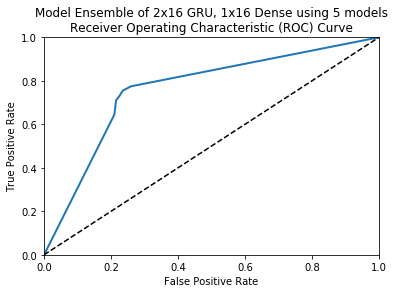

In [132]:
plt.plot(fpr2, tpr2, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Ensemble of 2x16 GRU, 1x16 Dense using 5 models\nReceiver Operating Characteristic (ROC) Curve')
plt.savefig('roc_ensmbl_gru.svg')

In [133]:
fpr2

array([0.   , 0.21 , 0.215, 0.225, 0.235, 0.26 , 1.   ])

In [134]:
threshold2

array([2. , 1. , 0.8, 0.6, 0.4, 0.2, 0. ])

In [135]:
tpr2

array([0.   , 0.645, 0.71 , 0.73 , 0.755, 0.775, 1.   ])

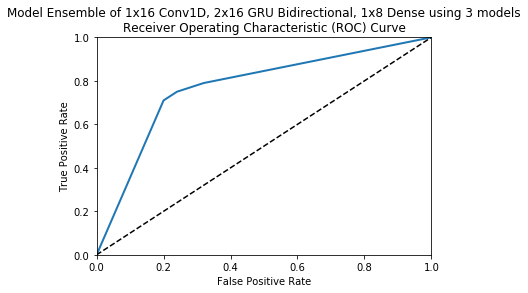

In [136]:
plt.plot(fpr3, tpr3, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Ensemble of 1x16 Conv1D, 2x16 GRU Bidirectional, 1x8 Dense using 3 models\nReceiver Operating Characteristic (ROC) Curve')
plt.savefig('roc_ensmbl_conv1d.svg')

In [137]:
fpr3

array([0.  , 0.2 , 0.24, 0.32, 1.  ])

In [138]:
threshold3

array([2.        , 1.        , 0.66666667, 0.33333333, 0.        ])

In [139]:
tpr3

array([0.  , 0.71, 0.75, 0.79, 1.  ])

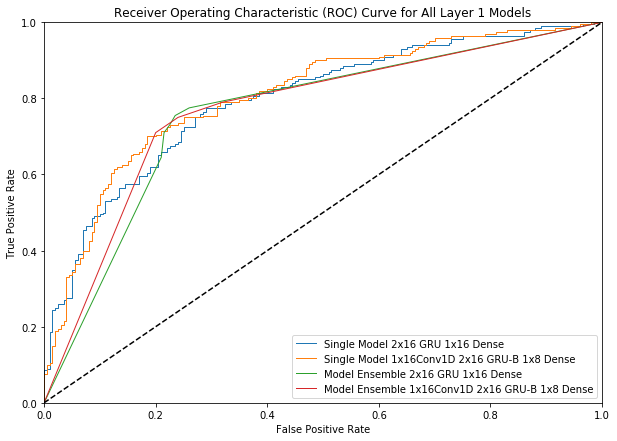

In [140]:
plt.figure(figsize=(10, 7))
plt.plot(fpr0, tpr0, linewidth=1, label='Single Model 2x16 GRU 1x16 Dense')
plt.plot(fpr1, tpr1, linewidth=1, label='Single Model 1x16Conv1D 2x16 GRU-B 1x8 Dense')
plt.plot(fpr2, tpr2, linewidth=1, label='Model Ensemble 2x16 GRU 1x16 Dense')
plt.plot(fpr3, tpr3, linewidth=1, label='Model Ensemble 1x16Conv1D 2x16 GRU-B 1x8 Dense')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for All Layer 1 Models')
plt.legend()
plt.savefig('roc_all.svg')